# Data Setup

In [1]:
import random
import numpy as np

import cudf
from cudf.datasets import randomdata

def valid_str():
    yield np.random.choice(['infinity', '-infinity', '+infinity', 'inf', '-inf', '+inf'])

def make_data(height):
    width_factor = 2
    valid_frac = 0.5

    strcol = randomdata(nrows=height, dtypes={'a': str})['a']._column
    for _ in range(1, width_factor):
        strcol = strcol.str().cat(others=strcol)
    
    valid_idx = np.random.choice(height, int(height * valid_frac), replace=False)
    
    return cudf.Series(strcol)

In [2]:
def regex_replace(s):
    s._column.str().replace("\\+?(inf|infinity)$", "Inf", regex=True)
    s._column.str().replace("-(inf|infinity)$", "-Inf", regex=True)
    
def literal_replace(s):
    s._column.str().replace("inf", "Inf", regex=False)
    s._column.str().replace("+inf", "Inf", regex=False)
    s._column.str().replace("infinity", "Inf", regex=False)
    s._column.str().replace("+infinity", "Inf", regex=False)
    s._column.str().replace("-inf", "-Inf", regex=False)
    s._column.str().replace("-infinity", "-Inf", regex=False)

def scatter_replace(s):
    s[(s == 'inf') | (s == '+inf') | (s == 'infinity') | (s == '+infinity')] = 'Inf'
    s[(s == '-inf') | (s == '-infinity')] = '-Inf'

def where_replace(s):
    s.where((s == 'inf') | (s == '+inf') | (s == 'infinity') | (s == '+infinity'), 'Inf')
    s.where((s == '-inf') | (s == '-infinity'), '-Inf')

In [3]:
import timeit

def run_and_time(repeats, f, *args):
    start = timeit.default_timer()
    for _ in range(repeats):
        f(*args)
    end = timeit.default_timer()
    return (end - start) / repeats

In [79]:
import pandas as pd

index = pd.Index(methods)
df = pd.DataFrame(index=index)

repeats = 100
for h in heights:
    s = make_data(h)
    
    regex_time = run_and_time(repeats, regex_replace, s)
    literal_time = run_and_time(repeats, literal_replace, s)
    scat_time = run_and_time(repeats, scatter_replace, s)
    where_time = run_and_time(repeats, where_replace, s)

    df[h] = [regex_time, literal_time, scat_time, where_time]
    

In [80]:
df

,1000,10000,100000,1000000,10000000
regex,0.001454,0.001396,0.002871,0.016433,0.137835
literal,0.002912,0.002917,0.002872,0.008556,0.035378
scat,0.009960,0.009906,0.013924,0.022500,0.060896
where,0.008747,0.008671,0.011087,0.021248,0.047949


In [81]:
%matplotlib inline

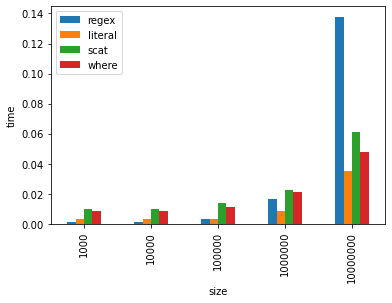

In [83]:
ax = df.T.plot.bar(xlabel='size', ylabel='time')